<a href="https://colab.research.google.com/github/mickymags/curriculum_development_initiative/blob/main/hydrafloods/training_materials/HF_Geo_4_Good_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

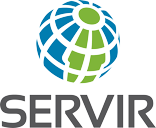

# Intro to Flood mapping using HYDRAFloods

In this notebook we will use HYDRAFloods to create a flood map. We will focus on the use of [Sentinel 1 SAR data](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/overview). While we focus only on SAR for this exercise, many of the concepts extend to optical data.

HYDRAFloods Python package can be found at: https://servir-mekong.github.io/hydra-floods/

This notebook shows:

1. Colab set-up and authenticate
2. Install HYDRAFloods package and other necessary packages
3. Pre-processing SAR imagery
4. Surface water detection
5. Pre and Post flood event
-Bonus-
6. Extraction of floods from permanent surface water
7. Classifcation Differencing



This notebook follows this HYDRAFloods Workflow for Sentinel-1 Imagery:



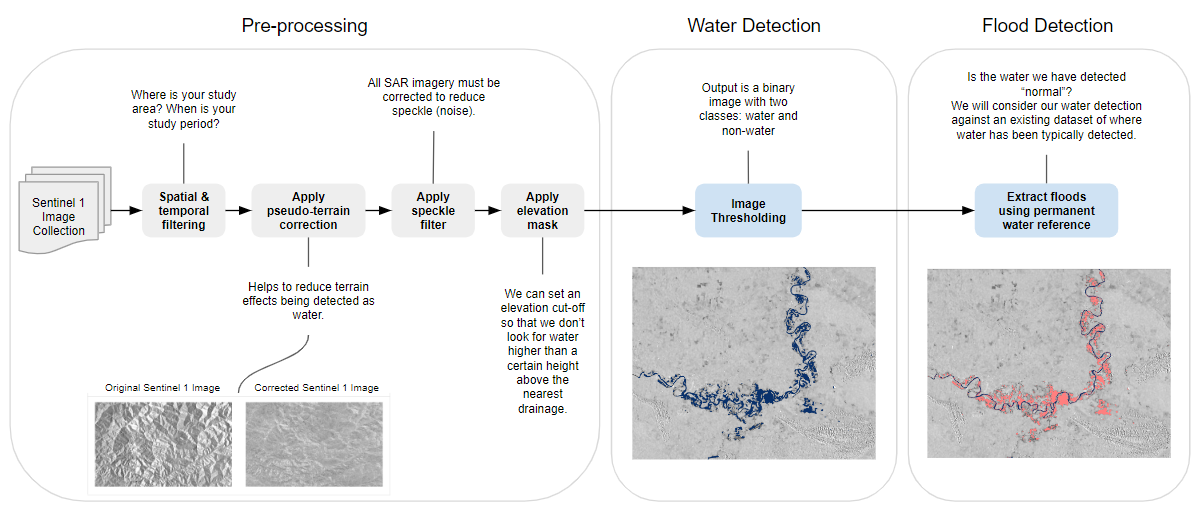

![alt text](https://colab.research.google.com/img/colab_favicon.ico)
## 1) Colab Setup and Authenticate

*   [Colab](https://colab.research.google.com/) is a FREE, Jupyter notebook style, python interface.
*   Use the same Google account between Colab, Cloud, and Google Earth Engine (GEE)




## 2) Install HYDRAFloods package and other necessary packages

The following cell installs the `hydrafloods` package for surface water mapping and `geemap` for interactive viewing results from GEE.

You will get and error stating "*You must restart the runtime in order to use newly installed versions.*" **This can not be ignored**. See the figure below that walks you through installing the HYRDAFloods package.

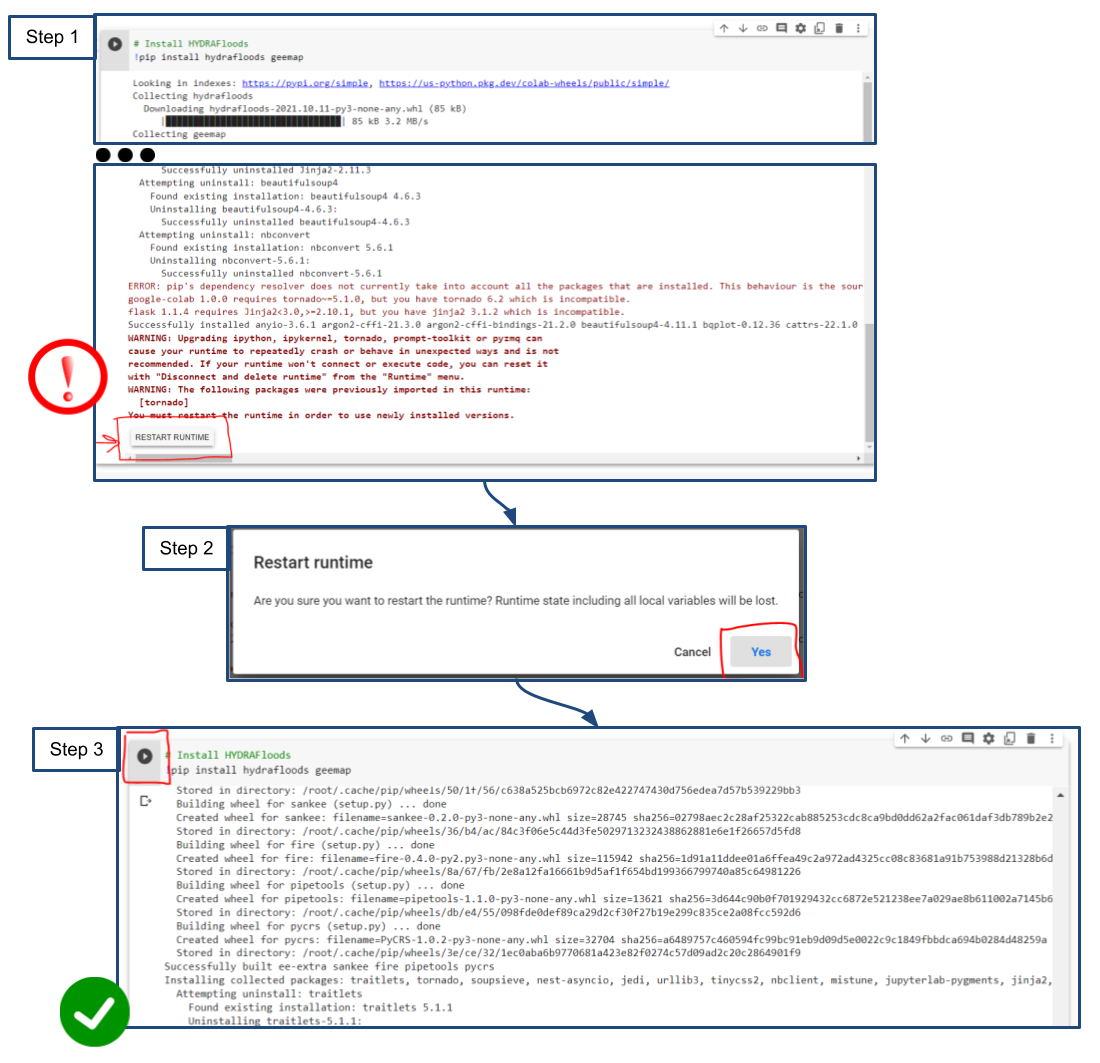

In [ ]:
# Install HYDRAFloods
!pip install hydrafloods geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import other needed packages

import ee
import datetime
import hydrafloods as hf
import geemap.eefolium as geemap
import geemap.colormaps as cm

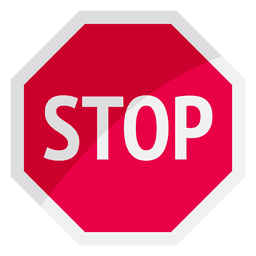

Before running the Colab any further take 1-2 minutes to get familiar with the set-up steps needed to fully connect your GEE account to your Colab instance.

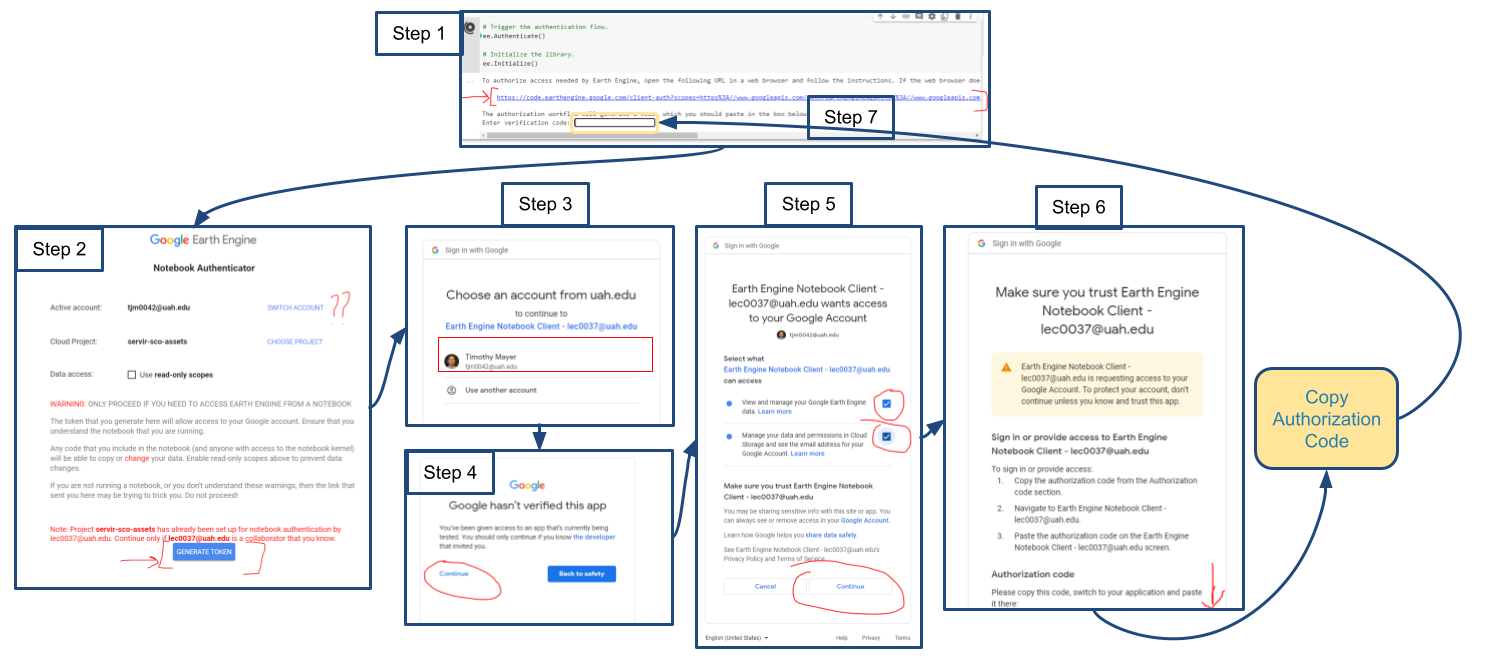


In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=jRaKXnMBnlic5lqhQ_OkczylxJsYKhIEUVUZJsayelc&tc=TqmCRzSTJ6Fx9ssVzB-p2w3Xf3RLqewHHNhVCUDq3Vc&cc=WexpKAlbvSA6EnJxz6neWjYPEu_rLvJJI3cnzEantA8

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvuidvB8C4Y8ZgleR1PsJ58fVwJI4rod4Q59QAC-TTE8uQYalTzBbys

Successfully saved authorization token.


In [ ]:
_ = geemap.Map()

In [ ]:
# Check the HYDRAFloods package version, the latest verison is "2021.10.11"

hf.__version__

'2021.10.11'

## 3) Pre-processing SAR imagery
The start of any process is to acquire data. Here HYDRAFloods is used to:
* Connect to Earth Engine collections to select the images we want using spatial and temporal filters
* Apply some standard corrections for pre-processing SAR images

In [ ]:
# Define region of interest for surface water mapping using an Earth Engine feature collection
# country = "Niger"

# Niamey, Niger 2021 flooding example study area
# region = ee.FeatureCollection( ee.Geometry.Polygon(
#        [[[1.4667740060133339, 14.334203660612241],
#          [1.4667740060133339, 12.951654621783488],
#          [3.411354084138334, 12.951654621783488],
#          [3.411354084138334, 14.334203660612241]]]))

# Nigeria 2022-10-01 - 2022-10-15 recent flooding example study area
region = ee.FeatureCollection( ee.Geometry.Polygon(
        [[[5.802569480394721, 8.05776009907258],
          [5.802569480394721, 5.155120559779507],
          [8.038287253832221, 5.155120559779507],
          [8.038287253832221, 8.05776009907258]]]))

# Option to select whole country as AOI
# ee.FeatureCollection(hf.country_bbox(country))

In [ ]:
region

In [ ]:
# Filter the image collection by the region of interest (defined above) and the time period of interest

# this time range will show relatively normal conditions (change to dates to start = "2022-10-01" and end = "2022-10-15" to see flooded conditions for comparison)
start = "2021-10-01"
end = "2021-10-15"

s1 = hf.Sentinel1(region, start, end)


In [ ]:
# Use this to check how many images are available for your geographic and time constraints
# Warning: If your time period and geographic area are large, this step could take a long time

s1.n_images

11

In [ ]:
# Bring in the MERIT Hydro dataset, a hydrologically adjusted DEM from Yamazaki, D. et al. 2019
# Learn more about MERIT Hydro here: http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro/

merit = ee.Image("MERIT/Hydro/v1_0_1")

# Extract out the DEM and HAND bands from MERIT Hydro

dem = merit.select("elv").unmask(0)
hand = merit.select("hnd").unmask(0)

In [ ]:
# Apply a (psuedo-) terrain flattening algorithm to S1 data
# elevation (ee.Image): Input DEM to calculate slope corrections from
# buffer (int, optional): buffer in meters for layover/shadow mask. If zero then no buffer will be applied. default = 0

s1_flat = s1.apply_func(hf.slope_correction, elevation=dem, buffer=100)

In [ ]:
# Apply a speckle filter algorithm to S1 data
# We are applying Gamma Map speckle filtering algorithm.
#   Algorithm adapted from https://groups.google.com/g/google-earth-engine-developers/c/a9W0Nlrhoq0/m/tnGMC45jAgAJ.
#
# For more information on speckle in SAR imagery, see SERVIR SAR Handbook, Chapter 2, pg 4: https://gis1.servirglobal.net/TrainingMaterials/SAR/Chp2Content.pdf

s1_filtered = s1_flat.apply_func(hf.gamma_map)

In [ ]:
# aggregate SAR observations to 30x30 m pixels

s1_aggregated = s1_filtered.apply_func(lambda x: x.focal_mean(40, "circle", "meters").reproject(ee.Projection("EPSG:4326").atScale(30)))

In [ ]:
# Define visualization parameters

sar_vis = {
    "bands":"VV",
    "min":-25,
    "max":0
}

In [ ]:
# Set the coordinates for the center of the map and the zoom level
# View the region of interest on the map
# View the mosaicked S1 imagery on the map

Map = geemap.Map(center=(6, -4), zoom=5)

Map.addLayer(region, {}, "Region of Interest")
Map.addLayer(s1_aggregated.collection.mosaic(), sar_vis, "Sentinel 1 Mosaic")

Map.addLayerControl()
Map

## 4) Surface Water Detection

#### Check your understanding:
*   At this point we have just performed some standard corrections for SAR imagery to prepare the data for water detection.

#### What's next?
*   In the next step we will apply a thresholding algorithm called [Edge Otsu](https://www.mdpi.com/2072-4292/12/15/2469) that outputs a binary image. The two classes will be water and non-water.
*   Next we will apply something called a [morphological filter](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) to help remove noise in our binary image.
* We will also use the hand band from [MERIT Hydro](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro/) to include only pixels that are less than 15 metres height above the nearest drainage.



In [ ]:
# Apply a water thresholding algorithm to the collection
# Method from Markert et al., 2020 (https://doi.org/10.3390/rs12152469)
# The output is a binary image. The two classes are water and non-water.

water = s1_filtered.apply_func(hf.edge_otsu, initial_threshold=-16, band="VV", edge_buffer=300, scale=180)

In [ ]:
water_mosaic = water.collection.mosaic()

In [ ]:
# Occurrence band is the frequency at which water was present (unit range 0-100%)

# max_extent = ee.Image("JRC/GSW1_3/GlobalSurfaceWater").select("occurrence").mask()

In [ ]:
# Apply two morphological filters (opening and closing) to help reduce noise in the image.
# Learn more about morphological transformations here:
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

water_final = (
    hf.close_binary(
        hf.open_binary(water_mosaic, window=1.5) # apply opening filter
        .updateMask(water_mosaic.mask()), # force mask to be consistent with sar imagery
        window=1.5
    ) # apply closing filter
    .updateMask(water_mosaic.mask()) # force mask to be consistent with sar imagery
    .And(hand.lt(15)) # only pixels that were originally classified as water AND < 15m from HAND (Height Above Nearest Drainage)
    # .And(max_extent))
)

In [ ]:
# View the results of SAR water mapping

Map = geemap.Map(center=(6, -4), zoom=5)

Map.addLayer(s1_aggregated.collection.median(),{"bands": "VV", "min":-25, "max": 0}, "Sentinel 1 Median")
Map.addLayer(water_final.selfMask(),{"min":0, "max":1, "palette":cm.palettes.Blues}, "Sentinel 1 (Water) From HF")

Map.addLayerControl()
Map

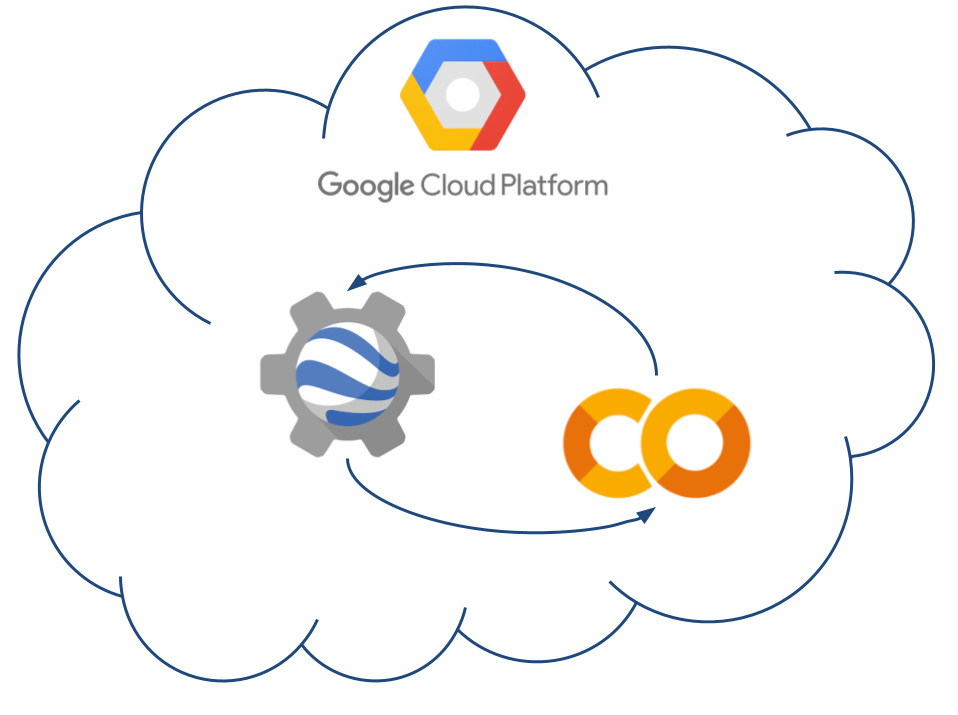

In [ ]:
export_img = s1_aggregated.collection.mosaic().addBands(water_final)
# The date stamp info gets lost in the mosaicing step, so let's put that info here
# date time information are used in the later stage to remove permanent water from the detected water
export_img = export_img.set("system:time_start", ee.Date(start).millis(), "system:time_end", ee.Date(end).millis())

# Checking to make sure its there
export_img.get("system:time_start").getInfo(), export_img.get("system:time_end").getInfo()


(1633046400000, 1634256000000)

In [ ]:
export_img.bandNames().getInfo()

['VV', 'VH', 'angle', 'local_inc_angle', 'water']

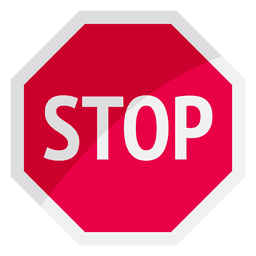

**Oppurtunity to update the code with your image Asset ID**

Check out an example of any [exported HydraFloods Image in GEE ](https://code.earthengine.google.com/40d9b46f799104c9917c0a8d40b4ec53)

In [ ]:
# MUST CHANGE "USERNAME" TO MATCH YOUR GEE ACOUNT IN THIS CELL BEFORE RUNNING #

# Export the water image to GEE assets
hf.export_image(
    export_img,
    region.geometry(),
    # geometry,
    description="hf_aoi_oct2021_nigeria",
    scale=30,
    crs="EPSG:4326",
    pyramiding={"water":"mode"},
    export_type="toAsset",
    asset_id="users/USERNAME/hf_aoi_oct2021_nigeria", ## Example ## "users/your_GEE_user_name/water_img_hf_nme"  ## Example ##
)

The asset export time depends on the size of your area of interest (AOI) used.

You can check the progress of your export using the[ GEE task manager](https://code.earthengine.google.com/tasks)

## 5) Pre- and post-event differencing



In [ ]:
# Start by pulling in a pre-computed water image we previously exported to our GEE assets

event_img =  ee.Image('users/tjm0042/water_img_hf_g4g') ## Example ## ee.Image("users/your_GEE_user_name/water_img_hf_nme") ## Example ##

sar_img = event_img.select("V.*")
water_img = event_img.select("water")

In [ ]:
# get imagery for a period before event
preevent = hf.Sentinel1Asc(region, "2020-09-01", "2020-10-01")

In [ ]:
# apply a (psuedo-) terrain flattening algorithm to S1 data
preevent_flat = preevent.apply_func(hf.slope_correction, elevation=dem, buffer=100)

In [ ]:
# apply a speckle filter algorithm to S1 data
preevent_filtered = preevent_flat.apply_func(hf.gamma_map)

In [ ]:
pre_img = preevent_filtered.collection.mean()

In [ ]:
pre_water = hf.edge_otsu(pre_img, band="VV", initial_threshold=-16, edge_buffer=300, region=region, scale=300)

In [ ]:
floods_diff = hf.discrete_difference(water_img, pre_water)

In [ ]:
# view the results of flood mapping
Map = geemap.Map(center=(16.0029, -90.5109), zoom=12)

Map.addLayer(pre_img,{"bands": "VV", "min":-25, "max": 0}, "pre-event Sentinel 1")
Map.addLayer(pre_water.selfMask(),{"min":0, "max":1, "palette":cm.palettes.Blues}, "pre-event water")
Map.addLayer(sar_img,{"bands": "VV", "min":-25, "max": 0}, "post-event Sentinel 1")
Map.addLayer(water_img.selfMask(),{"min":0, "max":1, "palette":"lightblue"}, "post-event water")
Map.addLayer(floods_diff.selfMask(),{"min":0, "max":1, "palette":"red"}, "Differenced Pre/Post Flood Image")

Map.addLayerControl()
Map

# ---------------Bonus Content---------------

## 6) Extraction of floods from permanent surface water

Now we will take our binary image (two classes: water and non-water) and extract floods from the water class.

* To extract floods we need some indicator of what is normal.
* The "normal" usually influence what the resulting flood map looks like.
* In these following cases we will use the [JRC surface water data](https://doi.org/10.1038/nature20584) to compare the event against and extract the flooded areas.

We will extract floods three different ways
1. Using yearly permanent water using
  [JRC Yearly Water Classification History, v1.2](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_2_YearlyHistory)

2. Using longterm occurrence using [JRC Global Surface Water Mapping Layers, v1.3](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_3_GlobalSurfaceWater)

3. Using seasonal information using [JRC Monthly Water Recurrence, v1.3 ](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_3_MonthlyRecurrence)

### Using yearly permanent water

For this case we will use previous 5-years of classified permanent water to compare against.

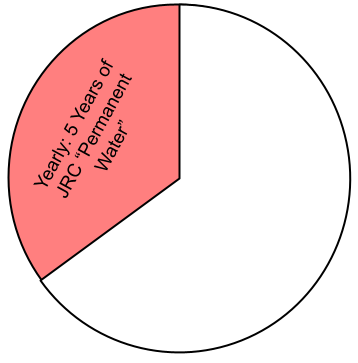

In [ ]:
# Note: We already ran this portion above, but we will run it again in case you're doing the bonus section only


event_img =  ee.Image('users/tjm0042/water_img_hf_g4g') ## Example ## ee.Image("users/your_GEE_user_name/water_img_hf_nme") ## Example ##

sar_img = event_img.select("V.*")
water_img = event_img.select("water")

In [ ]:
# Check that the image has a system start date

water_img.date().format("YYYY-MM-dd").getInfo()

'2020-11-06'

In [ ]:
# Use `extract_flood` function to use JRC data as reference
# yearly means it uses past 5 years of JRC yearly data and extract permanent water class

floods_yearly = hf.extract_flood(water_img, reference="yearly")

In [ ]:
# View the results of flood mapping

Map = geemap.Map(center=(16.0029, -90.5109), zoom=12)

Map.addLayer(sar_img, sar_vis, "Sentinel 1 Mosaic")
Map.addLayer(water_img.selfMask(), {"min":0, "max":1, "palette":cm.palettes.Blues}, "Sentinel 1 (water)")
Map.addLayer(floods_yearly.selfMask(), {"min":0, "max":1, "palette":"#FF7F7F"}, "Sentinel 1 (flood) Yearly")

Map.addLayerControl()
Map

### Using long-term occurrence

Here we use the full record of JRC observed water and define permanent using a % occurrence threshold. The occurence band provide information on the frequency with which water was present.

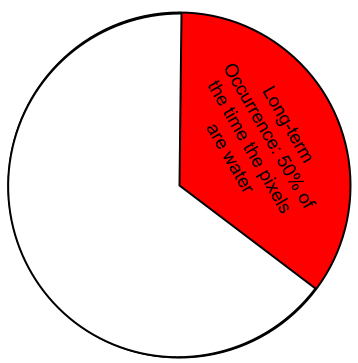

In [ ]:
# use `extract_flood` function to use JRC data as reference
floods_occurrence = hf.extract_flood(water_final, reference="occurrence", permanent_threshold=50)

In [ ]:
# view the results of flood mapping
Map = geemap.Map(center=(16.0029, -90.5109), zoom=12)

Map.addLayer(s1_aggregated.collection.median(),{"bands": "VV", "min":-25, "max": 0}, "Sentinel 1 Mosaic")
Map.addLayer(water_final.selfMask(),{"min":0, "max":1, "palette":cm.palettes.Blues}, "Sentinel 1 (water)")
Map.addLayer(floods_occurrence.selfMask(),{"min":0, "max":1, "palette":"red"}, "Sentinel 1 (flood) Long-term Occurrence")

Map.addLayerControl()
Map

### Using seasonal information

Here we will use the occurrence for the month that we observe to remove any effects of seasonality that is present in floods.

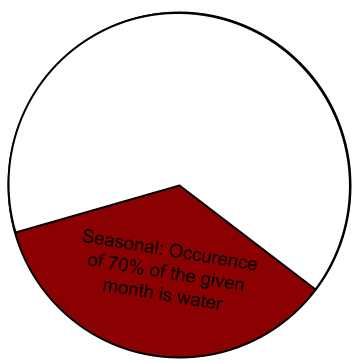

In [ ]:
# use `extract_flood` function to use JRC data as reference
# the dataset provides information on the recurrence value expressed as a percentage for the particular month (november in our case).
floods_seasonal = hf.extract_flood(water_img, reference="seasonal", permanent_threshold=70)

In [ ]:
# View the results of flood mapping
Map = geemap.Map(center=(16.0029, -90.5109), zoom=12)

Map.addLayer(sar_img,{"bands": "VV", "min":-25, "max": 0}, 'Sentinel 1')
Map.addLayer(water_img.selfMask(),{"min":0,"max":1,"palette":cm.palettes.Blues}, "Sentinel 1 (water)")
Map.addLayer(floods_seasonal.selfMask(),{"min":0, "max":1, "palette":"darkred"}, "Sentinel 1 (flood) Seasonal")

Map.addLayerControl()
Map

### Comparing the different approaches

Let put it all together

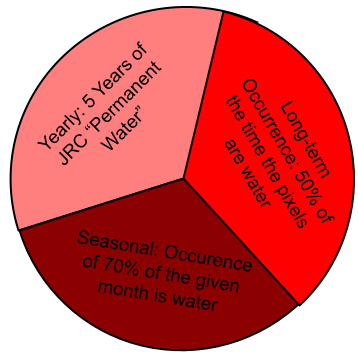

In [ ]:
# view the results of flood mapping
Map = geemap.Map(center=(16.0029, -90.5109), zoom=12)

Map.addLayer(s1_aggregated.collection.median(),{"bands": "VV", "min":-25, "max": 0}, "Sentinel 1")
Map.addLayer(water_final.selfMask(),{"min":0, "max":1, "palette":cm.palettes.Blues}, "Sentinel 1 (water)")
Map.addLayer(floods_yearly.selfMask(),{"min":0, "max":1, "palette":"#FF7F7F"}, "Sentinel 1 (yearly)")
Map.addLayer(floods_occurrence.selfMask(),{"min":0, "max":1, "palette":"red"}, "Sentinel 1 (ocurrence)")
Map.addLayer(floods_seasonal.selfMask(),{"min":0, "max":1, "palette":"darkred"}, "Sentinel 1 (seasonal)")

Map.addLayerControl()
Map

Any caveats to using these methods?

## 7) Classification differencing

### Change detection

In this case we we will use some change detection techniques to identify changes between a reference (pre-event) and post-event imagery. A famous algorithm for SAR is the [logarithmic amplitude ratio (LAR)](https://doi.org/10.1080/014311698215649). Here we will compute the LAR for a pair of pre- and post-event imagery and extract floods.

In [ ]:
# convert the db data to amplitude power
# then divide post/pre and take the log

# Read more about power, amplitude and db scale
# Section 3.4.3
# https://gis1.servirglobal.net/TrainingMaterials/SAR/SARHB_FullRes.pdf

lar = hf.db_to_power(sar_img.select("VV")).divide(hf.db_to_power(pre_img.select("VV"))).log10()

In [ ]:
floods_lar = hf.edge_otsu(lar, region=region, initial_threshold=0, scale=300, edge_buffer=300)

In [ ]:
floods_lar_final = (
    hf.close_binary(
        hf.open_binary(floods_lar, window=1.5) # apply opening filter
        .updateMask(floods_lar.mask()), # force mask to be consistent with sar imagery
        window=1.5
    ) # apply closing filter
    .updateMask(floods_lar.mask()) # force mask to be consistent with sar imagery
    .And(hand.lt(15)) # only pixels that were originally classified as water AND < 15m from HAND
)

In [ ]:
# view the results of flood mapping
Map = geemap.Map(center=(16.0029, -90.5109), zoom=12)

Map.addLayer(pre_img, {"bands": "VV", "min":-25, "max": 0}, "pre-event Sentinel 1")
Map.addLayer(sar_img, {"bands": "VV", "min":-25, "max": 0}, "post-event Sentinel 1")
Map.addLayer(lar, {"min":-1, "max":1, "palette":cm.palettes.inferno}, "LAR")
Map.addLayer(floods_lar_final.selfMask(), {"min":0, "max":1, "palette":"lightblue"}, "LAR event flooding")
Map.addLayer(floods_diff.selfMask(), {"min":0, "max":1, "palette":"red"}, "Differenced Pre/Post Flood Image")


Map.addLayerControl()
Map

EEException: ignored